In [1]:
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from geopy.distance import geodesic

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 16

import warnings
warnings.filterwarnings('ignore')

In [2]:
caldayinit   = 10
calmonthinit = 10
calyearinit  = 2016
daynumber    = np.arange(7)

headers = pd.read_csv('metadata/CSV.header.fieldids.csv')
datearg = int(headers['Column ID'][headers['Field Name']=='SQLDATE'])

for i in range(len(daynumber)):
    zf = zipfile.ZipFile('data/%d%d%d.export.CSV.zip'%(calyearinit,calmonthinit,caldayinit+daynumber[i])) 
    dftemp = pd.read_csv(zf.open('%d%d%d.export.CSV'%(calyearinit,calmonthinit,caldayinit+daynumber[i])), sep='\t',header=None)
    if i == 0:
        df = dftemp[dftemp.iloc[:,datearg]==int('%d%d%d'%(calyearinit,calmonthinit,caldayinit+daynumber[i]))]
    else:
        df = pd.concat([df,dftemp[dftemp.iloc[:,datearg]==int('%d%d%d'%(calyearinit,calmonthinit,caldayinit+daynumber[i]))]])

In [3]:
countrycodes = pd.read_csv('metadata/FIPS10-4_countrycodes.csv') # https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv
countrycodes = countrycodes[countrycodes['FIPS 10-4']!='-']
australiaarg = countrycodes.index[countrycodes['Name']=='Australia'].tolist()[0]

In [4]:
print('%d of %d records include an Actor1 country code (%d percent)'
      %(len(df[df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan']),
        len(df),
        (100*len(df[df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan'])/len(df))))

print('%d of %d records include an Actor1 country code where the Actor2 country code and Action country code are included and the same (%d percent)'
      %(len(df[(df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)==df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))]),
        len(df),
        (100*len(df[(df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)==df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))])/len(df))))

print('%d of %d records include an Actor1 country code different to the Actor2 country code and Action country code, which are included and the same (%d percent)'
      %(len(df[(df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)==df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!=df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))]),
        len(df),
        (100*len(df[(df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)!='nan')&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)==df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))&
               (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!=df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))])/len(df))))

df_filtered = df[(df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)!='nan')&
                 (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)!='nan')&
                 (df.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor2Geo_CountryCode'])].astype(str)==df.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str))]

1247326 of 1406083 records include an Actor1 country code (88 percent)
720788 of 1406083 records include an Actor1 country code where the Actor2 country code and Action country code are included and the same (51 percent)
107898 of 1406083 records include an Actor1 country code different to the Actor2 country code and Action country code, which are included and the same (7 percent)


In [5]:
country_centers   = np.empty((len(countrycodes),2))
country_geodesics = np.empty((len(countrycodes),len(countrycodes)))

for i in range(len(countrycodes)):
    df_temp0 = df_filtered[df_filtered.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str)==countrycodes.iloc[i,0]]
    templats = np.asarray(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_Lat'])])
    templons = np.asarray(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_Long'])])
    tempx = np.mean(np.cos(templats*np.pi/180)*np.cos(templons*np.pi/180))
    tempy = np.mean(np.cos(templats*np.pi/180)*np.sin(templons*np.pi/180))
    tempz = np.mean(np.sin(templats*np.pi/180))
    templon = np.arctan2(tempy,tempx)
    templat = np.arctan2(tempz,(tempx**2+tempy**2)**0.5)
    country_centers[i] = templon*180/np.pi,templat*180/np.pi
    
    print('%d of %d countries analysed'%((i+1),len(countrycodes)),end='\r')

for i in range(len(countrycodes)):
    for j in range(len(countrycodes)):
        if np.isnan(np.sum(country_centers[i])+np.sum(country_centers[j])):
            country_geodesics[i,j] = np.nan
        else:
            country_geodesics[i,j] = geodesic((country_centers[i,1],country_centers[i,0]), (country_centers[j,1],country_centers[j,0])).km

In [6]:
country_avgtone = np.empty(len(countrycodes))
country_stdtone = np.empty(len(countrycodes))
country_avgnart = np.empty(len(countrycodes))
country_stdnart = np.empty(len(countrycodes))

pairwisecountry_avgtone = np.empty((len(countrycodes),len(countrycodes)))
pairwisecountry_stdtone = np.empty((len(countrycodes),len(countrycodes)))
pairwisecountry_avgnart = np.empty((len(countrycodes),len(countrycodes)))
pairwisecountry_stdnart = np.empty((len(countrycodes),len(countrycodes)))

for i in range(len(countrycodes)):
    df_temp0 = df_filtered[df_filtered.iloc[:,int(headers['Column ID'][headers['Field Name']=='ActionGeo_CountryCode'])].astype(str)==countrycodes.iloc[i,0]]
    country_avgtone[i] = np.mean(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='AvgTone'])])
    country_stdtone[i] = np.std(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='AvgTone'])])
    country_avgnart[i] = np.mean(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='NumArticles'])])
    country_stdnart[i] = np.std(df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='NumArticles'])])
    
    for j in range(len(countrycodes)):
        df_temp1 = df_temp0[df_temp0.iloc[:,int(headers['Column ID'][headers['Field Name']=='Actor1Geo_CountryCode'])].astype(str)==countrycodes.iloc[j,0]]
        pairwisecountry_avgtone[i,j] = np.mean(df_temp1.iloc[:,int(headers['Column ID'][headers['Field Name']=='AvgTone'])])
        pairwisecountry_stdtone[i,j] = np.std(df_temp1.iloc[:,int(headers['Column ID'][headers['Field Name']=='AvgTone'])])
        pairwisecountry_avgnart[i,j] = np.mean(df_temp1.iloc[:,int(headers['Column ID'][headers['Field Name']=='NumArticles'])])
        pairwisecountry_stdnart[i,j] = np.std(df_temp1.iloc[:,int(headers['Column ID'][headers['Field Name']=='NumArticles'])])
        
    print('%d of %d countries analysed'%((i+1),len(countrycodes)),end='\r')

In [7]:
pairwisecountry_avgtone_normed = (pairwisecountry_avgtone-country_avgtone)/country_stdtone
pairwisecountry_avgtone_normed[np.isinf(pairwisecountry_avgtone_normed)] = np.nan

pairwisecountry_avgnart_normed = pairwisecountry_avgnart/country_avgnart
pairwisecountry_avgnart_normed[np.isinf(pairwisecountry_avgnart_normed)] = np.nan

Text(0.5, 1.0, 'World, October 10-16 2016. Sorted by average\n tone of reporting on domestic events (low to high)')

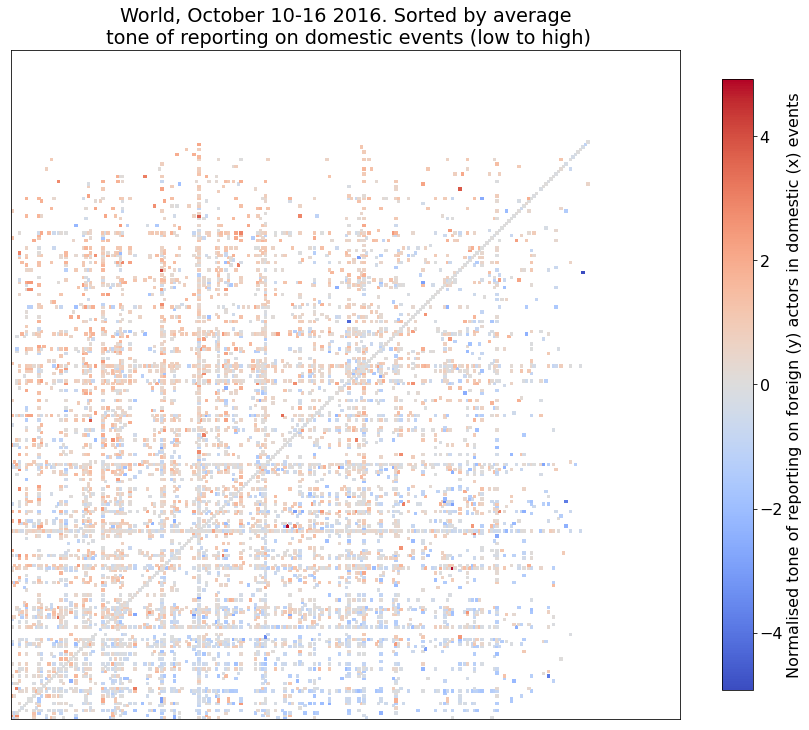

In [8]:
vabsmax = np.nanmax(np.abs(pairwisecountry_avgtone_normed))

plt.pcolormesh(pairwisecountry_avgtone_normed[np.argsort(country_avgtone),:][:,np.argsort(country_avgtone)],cmap='coolwarm',vmin=-vabsmax,vmax=vabsmax)
plt.colorbar(shrink=0.75,label='Normalised tone of reporting on foreign (y) actors in domestic (x) events')

plt.axis('square')
plt.xticks([])
plt.yticks([])

plt.title('World, October 10-16 2016. Sorted by average\n tone of reporting on domestic events (low to high)')

In [9]:
country_avgtone_normed_corrcoeff = np.empty(len(countrycodes))

mincountriesfor_country_avgtone_normed_corrcoeff = 5

for i in range(len(countrycodes)):
    if len(countrycodes[~np.isnan(pairwisecountry_avgtone_normed[:,i])&~np.isnan(pairwisecountry_avgtone_normed[i,:])])>mincountriesfor_country_avgtone_normed_corrcoeff:
        country_avgtone_normed_corrcoeff[i] = np.corrcoef(pairwisecountry_avgtone_normed[~np.isnan(pairwisecountry_avgtone_normed[:,i])&~np.isnan(pairwisecountry_avgtone_normed[i,:]),i],
                                                          pairwisecountry_avgtone_normed[i,~np.isnan(pairwisecountry_avgtone_normed[:,i])&~np.isnan(pairwisecountry_avgtone_normed[i,:])])[1,0]
    else:
        country_avgtone_normed_corrcoeff[i] = np.nan

Angola
Bahamas, The
Brazil
Bulgaria
Burma
Central African Republic
Chile
Costa Rica
Cyprus
Czech Republic
Denmark
Ecuador
Estonia
Haiti
Indonesia
Jordan
Laos
Malawi
Morocco
Myanmar
Norway
Papua New Guinea
Peru
Portugal
Rwanda
Saudi Arabia
Sierra Leone
Singapore
Solomon Islands
Somalia
Syria
Uganda
United Arab Emirates
Yemen


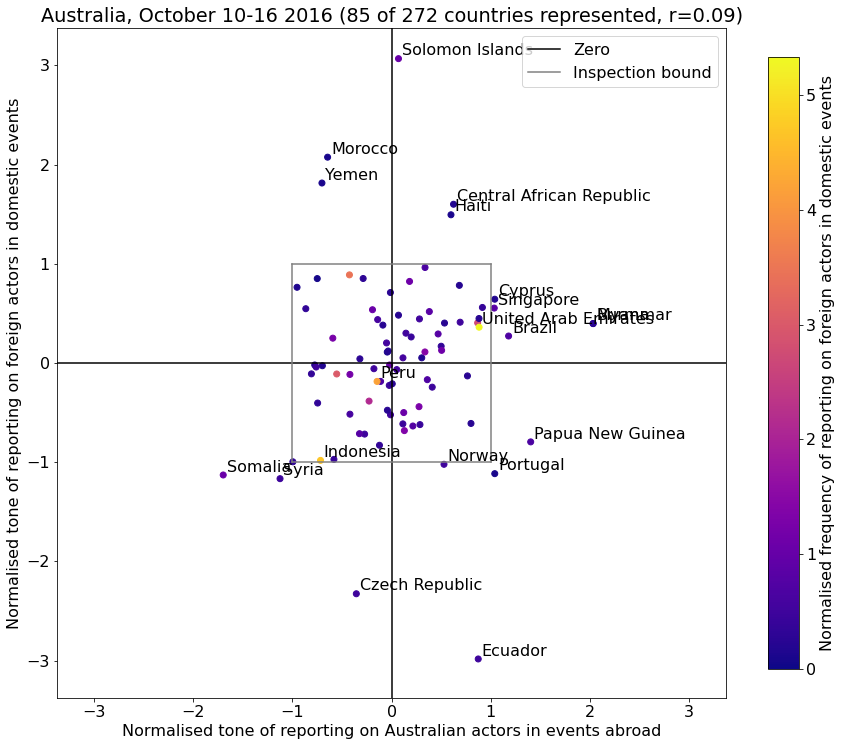

In [10]:
vabsaxes = 1.1*np.nanmax(np.abs(np.hstack((pairwisecountry_avgtone_normed[:,australiaarg],pairwisecountry_avgtone_normed[australiaarg,:]))))
vabscbar = 1.0*np.nanmax(np.abs(pairwisecountry_avgnart_normed[australiaarg,:]))

plt.scatter(pairwisecountry_avgtone_normed[:,australiaarg],pairwisecountry_avgtone_normed[australiaarg,:],
            c=pairwisecountry_avgnart_normed[australiaarg,:],cmap='plasma',vmin=0,vmax=vabscbar)

plt.colorbar(shrink=0.75,label='Normalised frequency of reporting on foreign actors in domestic events')

plt.plot([0,0],[-vabsaxes,vabsaxes],'k',label='Zero')
plt.plot([-vabsaxes,vabsaxes],[0,0],'k')

plt.plot([-1, 1],[ 1, 1],'grey',label='Inspection bound')
plt.plot([-1, 1],[-1,-1],'grey')
plt.plot([ 1, 1],[-1, 1],'grey')
plt.plot([-1,-1],[-1, 1],'grey')

tempcountrysetargs = np.unique(np.hstack((np.squeeze(np.argwhere(np.abs(pairwisecountry_avgtone_normed[:,australiaarg])>1)),
                                          np.squeeze(np.argwhere(np.abs(pairwisecountry_avgtone_normed[australiaarg,:])>1)),
                                          np.squeeze(np.argwhere(pairwisecountry_avgnart_normed[australiaarg,:]>4)))))

for i in range(len(tempcountrysetargs)):
    plt.annotate(countrycodes.iloc[tempcountrysetargs[i],1],(pairwisecountry_avgtone_normed[tempcountrysetargs[i],australiaarg]+vabsaxes*1e-2,
                                                             pairwisecountry_avgtone_normed[australiaarg,tempcountrysetargs[i]]+vabsaxes*1e-2))
    print(countrycodes.iloc[tempcountrysetargs[i],1])

plt.axis('square')
plt.xlim(-vabsaxes,vabsaxes)
plt.ylim(-vabsaxes,vabsaxes)

tempncountry = pairwisecountry_avgtone_normed[:,australiaarg]+pairwisecountry_avgtone_normed[australiaarg,:]
tempncountry = len(tempncountry[~np.isnan(tempncountry)])
tempcorrcoef = country_avgtone_normed_corrcoeff[australiaarg]
plt.title('Australia, October 10-16 2016 (%d of %d countries represented, r=%.2f)'%(tempncountry,len(countrycodes),tempcorrcoef))

plt.xlabel('Normalised tone of reporting on Australian actors in events abroad')
plt.ylabel('Normalised tone of reporting on foreign actors in domestic events')
plt.legend()

Antigua and Barbuda
Austria
Bahamas, The
Baker Island
Belarus
Bolivia
Bosnia and Herzegovina
Brunei
Chad
Comoros
Cote d'Ivoire
Croatia
Czech Republic
Europa Island
Finland
Gaza Strip
Glorioso Islands
Guadeloupe
Guatemala
Guinea-Bissau
Guyana
Iceland
Iraq
Isle of Man
Korea, North
Macedonia
Mayotte
Micronesia, Federated States of
Monaco
Montserrat
Australia


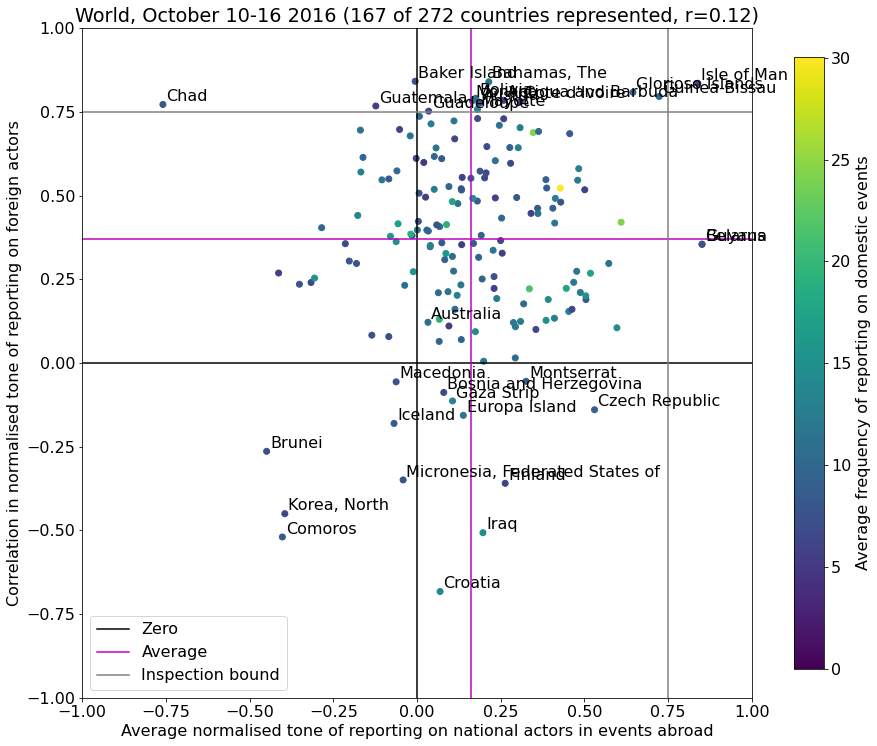

In [11]:
vabsaxes = 1

tempx = np.nanmean(pairwisecountry_avgtone_normed,axis=0)[~np.isnan(np.nanmean(pairwisecountry_avgtone_normed,axis=0))&~np.isnan(country_avgtone_normed_corrcoeff)]
tempy = country_avgtone_normed_corrcoeff[~np.isnan(np.nanmean(pairwisecountry_avgtone_normed,axis=0))&~np.isnan(country_avgtone_normed_corrcoeff)]
tempz = country_avgnart[~np.isnan(np.nanmean(pairwisecountry_avgtone_normed,axis=0))&~np.isnan(country_avgtone_normed_corrcoeff)]

plt.scatter(tempx,tempy,c=tempz,vmin=0,vmax=np.max(tempz))
plt.colorbar(shrink=0.75,label='Average frequency of reporting on domestic events')

plt.plot([0,0],[-vabsaxes,vabsaxes],'k',label='Zero')
plt.plot([-vabsaxes,vabsaxes],[0,0],'k')

plt.plot([np.mean(tempx),np.mean(tempx)],[-vabsaxes,vabsaxes],'m',label='Average')
plt.plot([-vabsaxes,vabsaxes],[np.mean(tempy),np.mean(tempy)],'m')
plt.plot([-vabsaxes,vabsaxes],[0.75,0.75],'grey',label='Inspection bound')
plt.plot([0.75,0.75],[-vabsaxes,vabsaxes],'grey')


tempcountrysetargs = np.unique(np.hstack((np.squeeze(np.argwhere(tempx>0.75)),
                                          np.squeeze(np.argwhere(tempy>0.75)),
                                          np.squeeze(np.argwhere(tempy<0)))))
tempcountrysetargs = np.append(tempcountrysetargs,australiaarg)

for i in range(len(tempcountrysetargs)):
    plt.annotate(countrycodes.iloc[tempcountrysetargs[i],1],(tempx[tempcountrysetargs[i]]+vabsaxes*1e-2,
                                                             tempy[tempcountrysetargs[i]]+vabsaxes*1e-2))
    print(countrycodes.iloc[tempcountrysetargs[i],1])

plt.axis('square')
plt.xlim(-vabsaxes,vabsaxes)
plt.ylim(-vabsaxes,vabsaxes)

tempncountry = len(tempx)
tempcorrcoef = np.corrcoef(tempx,tempy)[1,0]
plt.title('World, October 10-16 2016 (%d of %d countries represented, r=%.2f)'%(tempncountry,len(countrycodes),tempcorrcoef))

plt.xlabel('Average normalised tone of reporting on national actors in events abroad')
plt.ylabel('Correlation in normalised tone of reporting on foreign actors')
plt.legend()

Niue in Cook Islands
Jordan in Egypt
Micronesia, Federated States of in Malaysia
Solomon Islands in Australia
Israel in Austria
Morocco in Belgium
Burundi in Ethiopia
Qatar in Kazakhstan
Zambia in Madagascar
Djibouti in Sudan


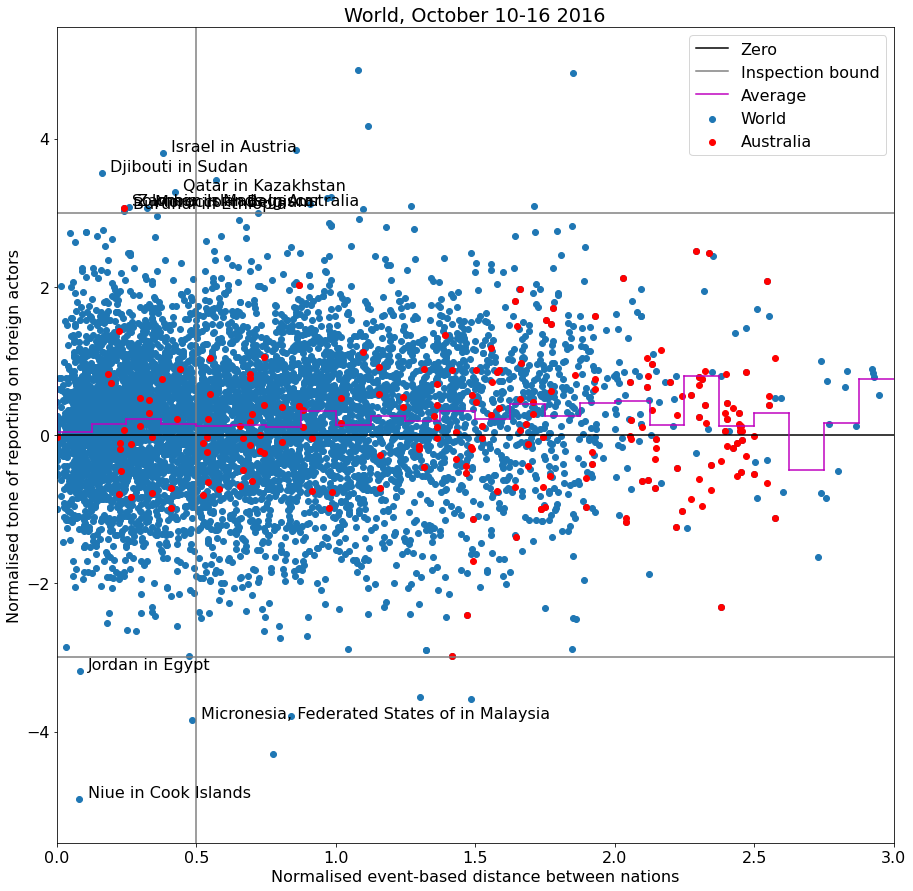

In [12]:
xminaxis = 0
xmaxaxis = 3
yminaxis = -5.5
ymaxaxis = 5.5

xabsaxes = xmaxaxis-xminaxis
yabsaxis = ymaxaxis-yminaxis

plt.scatter(np.ndarray.flatten(country_geodesics/np.nanmean(country_geodesics,axis=0)),np.ndarray.flatten(pairwisecountry_avgtone_normed),label='World')

plt.scatter(country_geodesics[:,australiaarg]/np.nanmean(country_geodesics,axis=0),pairwisecountry_avgtone_normed[:,australiaarg],c='r',label='Australia')
plt.scatter(country_geodesics[australiaarg,:]/np.nanmean(country_geodesics,axis=0),pairwisecountry_avgtone_normed[australiaarg,:],c='r')


tempcountrysetargs = np.vstack((np.vstack(np.where((country_geodesics/np.nanmean(country_geodesics,axis=0)<0.5)&(pairwisecountry_avgtone_normed<-3))).T,
                                np.vstack(np.where((country_geodesics/np.nanmean(country_geodesics,axis=0)<0.5)&(pairwisecountry_avgtone_normed> 3))).T))

for i in range(len(tempcountrysetargs)):
    plt.annotate(countrycodes.iloc[tempcountrysetargs[i,1],1]+' in '+countrycodes.iloc[tempcountrysetargs[i,0],1],
                 ((country_geodesics/np.nanmean(country_geodesics,axis=0))[tempcountrysetargs[i,0],tempcountrysetargs[i,1]]+xabsaxes*1e-2,
                  pairwisecountry_avgtone_normed[tempcountrysetargs[i,0],tempcountrysetargs[i,1]]+xabsaxes*1e-2))
    
    print(countrycodes.iloc[tempcountrysetargs[i,1],1]+' in '+countrycodes.iloc[tempcountrysetargs[i,0],1])

plt.plot([xminaxis,xmaxaxis],[ 0 ,0],c='k',label='Zero')
plt.plot([xminaxis,xmaxaxis],[ 3, 3],c='grey')
plt.plot([xminaxis,xmaxaxis],[-3,-3],c='grey')
plt.plot([0.5,0.5],[yminaxis,ymaxaxis],c='grey',label='Inspection bound')

ntempxbins = 25
tempxbins = np.linspace(xminaxis,xmaxaxis,ntempxbins)
tempy = np.empty(ntempxbins-1)
for i in range(ntempxbins-1):
    tempy[i] = np.nanmean(np.ndarray.flatten(pairwisecountry_avgtone_normed)[(np.ndarray.flatten(country_geodesics/np.nanmean(country_geodesics,axis=0))>tempxbins[i])&
                                                                          (np.ndarray.flatten(country_geodesics/np.nanmean(country_geodesics,axis=0))<=tempxbins[i+1])])
for i in range(ntempxbins-1):
    if i==0:
        plt.plot(tempxbins[i:i+2],[tempy[i],tempy[i]],c='m',label='Average')
    else:
        plt.plot(tempxbins[i:i+2],[tempy[i],tempy[i]],c='m')
    plt.plot([tempxbins[i],tempxbins[i]],[tempy[i-1],tempy[i]],c='m')
    
plt.xlim(xminaxis,xmaxaxis)
plt.ylim(yminaxis,ymaxaxis)

plt.title('World, October 10-16 2016')

plt.ylabel('Normalised tone of reporting on foreign actors')
plt.xlabel('Normalised event-based distance between nations')
plt.legend()